# UC San Diego MBB Performance Analysis
# By Wael Ivie
## 2/4/20 (Work in progress..)

In [23]:
#Importing packages
#
# You can delete whatever package(s) you chose..
#

import math as m
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# Leave This code here and lookup at pandas documentation 
# if you need to know about chained assignments
pd.options.mode.chained_assignment = None  # default='warn'

# Because most of my data sets I have made can have up to 30+ columns and 20+ rows
# code below will increase pandas defaults for max rows 
# and columns that you can display in a Juptyer Notebook
pd.options.display.max_columns = 60
pd.options.display.max_rows = 99

## Intro

This analysis will dive deeper into the UCSD mens basketball team's off performance against both man and zone defenses by

utilizing the data I have collected from Synergy and some from HoopsIQ along with some python. The purpose of this is

because we are interested in what the teams offensive strengths have been this season against certain defenses, and 

if I find the time I will try to go back through other seasons as well. We might be able to use this data for the 

future as we move as a university athletic program into the NCAA division 1, but for now we are just exploring and 

analyzing if what the coaches and I see in performance actually shows in the metrics. 

In [24]:
# Let's use the data we have on our play types vs zone defenses
playtypes_zone = pd.read_excel('OffvsMan_Zone19_20.xlsx', sheet_name='playtypesVsZone')

In [25]:
playtypes_zone

,Play Types,% Time,Poss,Points,PPP,Rank,Rating,FGm,FGM,FGA,FG%,aFG%,%TO,%FT,%SF,%Score
0,Spot Up,0.655,235,276,1.174,0.84,Excellent,115,91,206,0.442,0.629,0.085,0.047,0.038,0.426
1,Cut,0.139,50,68,1.36,0.92,Excellent,9,26,35,0.743,0.743,0.12,0.22,0.2,0.7
2,Post-Up,0.047,17,11,0.647,0.3,Below Average,7,4,11,0.364,0.364,0.235,0.118,0.118,0.353
3,Offensive Rebounds (put backs),0.033,12,15,1.25,0.74,Very Good,4,7,11,0.636,0.636,0.083,0.083,0.083,0.583
4,P&R Ball Handler,0.031,11,8,0.727,0.49,Average,3,3,6,0.5,0.583,0.364,0.091,0,0.364
5,P&R Roll Man,0.017,6,4,0.667,-,-,2,2,4,0.5,0.5,0.167,0.167,0.167,0.333
6,Isolation,0.014,5,4,0.8,-,-,1,1,2,0.5,0.5,0.4,0.2,0.2,0.4
7,Hand Off,0.014,5,0,0,-,-,4,0,4,0,0,0.2,0,0,0
8,Off Screen,0.006,2,6,3,-,-,0,2,2,1,1.5,0,0,0,1
9,Transition,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-


In [26]:
# I am going to go ahead and drop the "Transition" row
# due to no recorded data
playtypes_zone = playtypes_zone.drop([9])

In [27]:
# Adding a column for points per 100 possesions
playtypes_zone['PPer100P'] = 100*playtypes_zone['PPP']

In [28]:
playtypes_zone

,Play Types,% Time,Poss,Points,PPP,Rank,Rating,FGm,FGM,FGA,FG%,aFG%,%TO,%FT,%SF,%Score,PPer100P
0,Spot Up,0.655,235,276,1.174,0.84,Excellent,115,91,206,0.442,0.629,0.085,0.047,0.038,0.426,117.4
1,Cut,0.139,50,68,1.36,0.92,Excellent,9,26,35,0.743,0.743,0.12,0.22,0.2,0.7,136
2,Post-Up,0.047,17,11,0.647,0.3,Below Average,7,4,11,0.364,0.364,0.235,0.118,0.118,0.353,64.7
3,Offensive Rebounds (put backs),0.033,12,15,1.25,0.74,Very Good,4,7,11,0.636,0.636,0.083,0.083,0.083,0.583,125
4,P&R Ball Handler,0.031,11,8,0.727,0.49,Average,3,3,6,0.5,0.583,0.364,0.091,0,0.364,72.7
5,P&R Roll Man,0.017,6,4,0.667,-,-,2,2,4,0.5,0.5,0.167,0.167,0.167,0.333,66.7
6,Isolation,0.014,5,4,0.8,-,-,1,1,2,0.5,0.5,0.4,0.2,0.2,0.4,80
7,Hand Off,0.014,5,0,0,-,-,4,0,4,0,0,0.2,0,0,0,0
8,Off Screen,0.006,2,6,3,-,-,0,2,2,1,1.5,0,0,0,1,300
10,Miscellaneous,0.045,16,5,0.312,0.65,Very Good,1,1,2,0.5,0.75,0.813,0.063,0,0.125,31.2


In [70]:
Expected_PPP_againstZone = sum(playtypes_zone['PPP'])/len(playtypes_zone['PPP'])
Expected_PPP_againstZone

0.9936999999999999

In [31]:
# I want multiply all the percents by 100 to make them into whole numbers 
# in order to make the rest of analysis easier to follow
# The code below will do that...

percent_cols=['% Time','FG%','aFG%','%TO','%FT','%SF','%Score']
normalize = 100

for column in playtypes_zone.columns:
    if column in percent_cols:
        playtypes_zone[column]=playtypes_zone[column]*normalize


In [32]:
playtypes_zone

,Play Types,% Time,Poss,Points,PPP,Rank,Rating,FGm,FGM,FGA,FG%,aFG%,%TO,%FT,%SF,%Score,PPer100P
0,Spot Up,65.5,235,276,1.174,0.84,Excellent,115,91,206,44.2,62.9,8.5,4.7,3.8,42.6,117.4
1,Cut,13.9,50,68,1.36,0.92,Excellent,9,26,35,74.3,74.3,12,22,20,70,136
2,Post-Up,4.7,17,11,0.647,0.3,Below Average,7,4,11,36.4,36.4,23.5,11.8,11.8,35.3,64.7
3,Offensive Rebounds (put backs),3.3,12,15,1.25,0.74,Very Good,4,7,11,63.6,63.6,8.3,8.3,8.3,58.3,125
4,P&R Ball Handler,3.1,11,8,0.727,0.49,Average,3,3,6,50,58.3,36.4,9.1,0,36.4,72.7
5,P&R Roll Man,1.7,6,4,0.667,-,-,2,2,4,50,50,16.7,16.7,16.7,33.3,66.7
6,Isolation,1.4,5,4,0.8,-,-,1,1,2,50,50,40,20,20,40,80
7,Hand Off,1.4,5,0,0,-,-,4,0,4,0,0,20,0,0,0,0
8,Off Screen,0.6,2,6,3,-,-,0,2,2,100,150,0,0,0,100,300
10,Miscellaneous,4.5,16,5,0.312,0.65,Very Good,1,1,2,50,75,81.3,6.3,0,12.5,31.2


In [33]:
playtypes_zone.sort_values(by='PPer100P', ascending=False)


,Play Types,% Time,Poss,Points,PPP,Rank,Rating,FGm,FGM,FGA,FG%,aFG%,%TO,%FT,%SF,%Score,PPer100P
8,Off Screen,0.6,2,6,3,-,-,0,2,2,100,150,0,0,0,100,300
1,Cut,13.9,50,68,1.36,0.92,Excellent,9,26,35,74.3,74.3,12,22,20,70,136
3,Offensive Rebounds (put backs),3.3,12,15,1.25,0.74,Very Good,4,7,11,63.6,63.6,8.3,8.3,8.3,58.3,125
0,Spot Up,65.5,235,276,1.174,0.84,Excellent,115,91,206,44.2,62.9,8.5,4.7,3.8,42.6,117.4
6,Isolation,1.4,5,4,0.8,-,-,1,1,2,50,50,40,20,20,40,80
4,P&R Ball Handler,3.1,11,8,0.727,0.49,Average,3,3,6,50,58.3,36.4,9.1,0,36.4,72.7
5,P&R Roll Man,1.7,6,4,0.667,-,-,2,2,4,50,50,16.7,16.7,16.7,33.3,66.7
2,Post-Up,4.7,17,11,0.647,0.3,Below Average,7,4,11,36.4,36.4,23.5,11.8,11.8,35.3,64.7
10,Miscellaneous,4.5,16,5,0.312,0.65,Very Good,1,1,2,50,75,81.3,6.3,0,12.5,31.2
7,Hand Off,1.4,5,0,0,-,-,4,0,4,0,0,20,0,0,0,0


- Okay so now that we have the data in a fairly readable format let us make some plots..

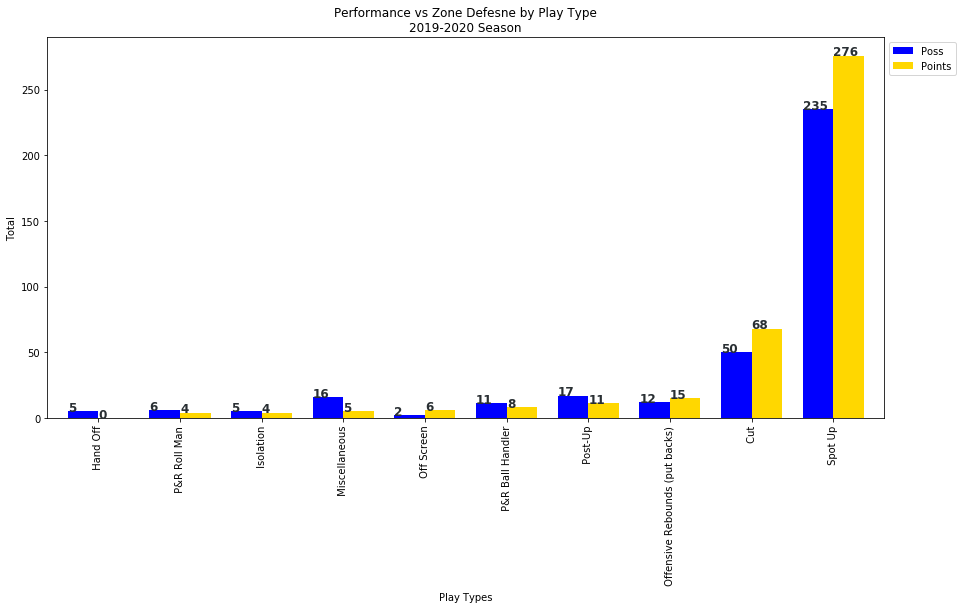

In [34]:
ax = playtypes_zone.sort_values(by='Points').plot(x='Play Types', y=['Poss','Points'], kind="bar",width=.75,color=['Blue','Gold','red'],figsize=(15,7))
plt.ylabel('Total'),plt.title("Performance vs Zone Defesne by Play Type\n2019-2020 Season")
lgd = plt.legend(loc='upper left', bbox_to_anchor=(1,1))
for i in ax.patches:
    ax.text(i.get_x()+.003, i.get_height()+0.09, \
            str(round((i.get_height()), 2)), fontsize=12, color='#292f33',
                rotation=0,weight='bold')
plt.savefig('Performance_Zone_Def_Play_Type.png',bbox_extra_artists=(lgd,),bbox_inches='tight',dpi=130)

The first thing I want to see is what plays resulted in the most possessions and points and get a sense of what is the go to offensive play type when we are faced against zone. We can see that Spot Up plays are the go to and result in a lot of the points.


This is interesting because it is a result of great ball movement, decision making, and ability in getting to open gaps in the zone to take uncontested spot up jumpers. 

When looking at games like the one from 2/1/20 against Stanislaus State, they played zone to slow us down to some extent and cause confusion but more importantly force people to make spot up shots, which we struggled with for a while. However, due to the consistent defense and our offense ability to keep the ball moving side to side and penetrate the lanes we were able to still break down the zone. 

Next I want to see is what play types are most efficient based on Points per 100 possesions and turnover percentage or rate. 

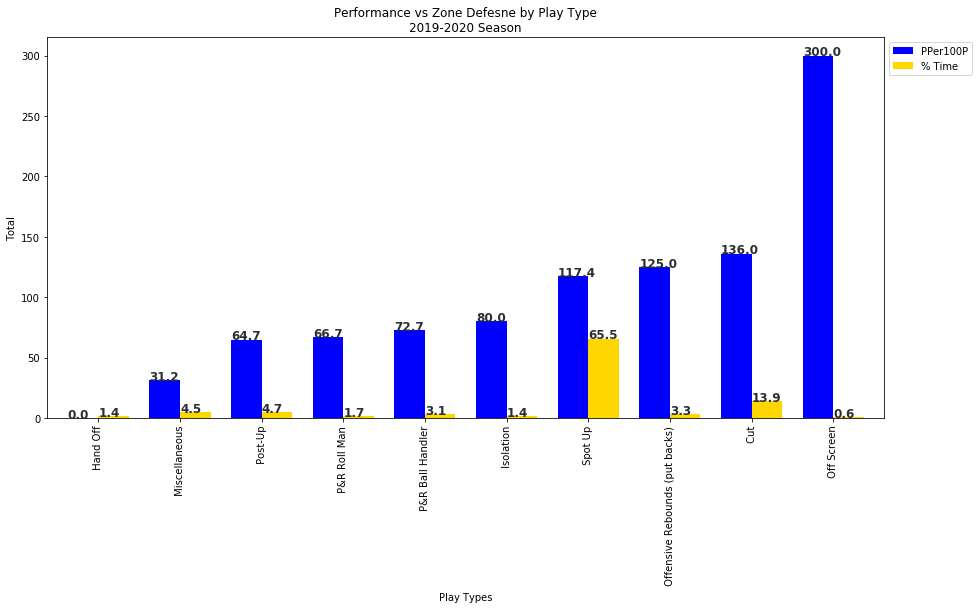

In [35]:
ax = playtypes_zone.sort_values(by='PPer100P').plot(x='Play Types', y=['PPer100P','% Time'], kind="bar",width=.75,color=['Blue','Gold','red'],figsize=(15,7))
plt.ylabel('Total'),plt.title("Performance vs Zone Defesne by Play Type\n2019-2020 Season")
lgd = plt.legend(loc='upper left', bbox_to_anchor=(1,1))
for i in ax.patches:
    ax.text(i.get_x()+.003, i.get_height()+0.09, \
            str(round((i.get_height()), 2)), fontsize=12, color='#292f33',
                rotation=0,weight='bold')

Now we can see the in barchart above that it would appear that the "Off Screen" plays against zone defense this year has been the best, but since this is based on a very small sample size of just 2 possesions I would suggest it is not very significant and we already know most the possessions and points are from "Spot Ups" play types. 


In the bar chart below that has turnover rate along with points per 100 possesions for each play type we can see that the play types that yield the highest points per possession against zone defense. The plays with the best net results along with low turnover rates are Offensive Putbacks, Spot Ups, and Cuts. Of these three play types the one we play the use the most is Spots Ups which has a very low turnover rate of 8.5% and a high points per possesion.

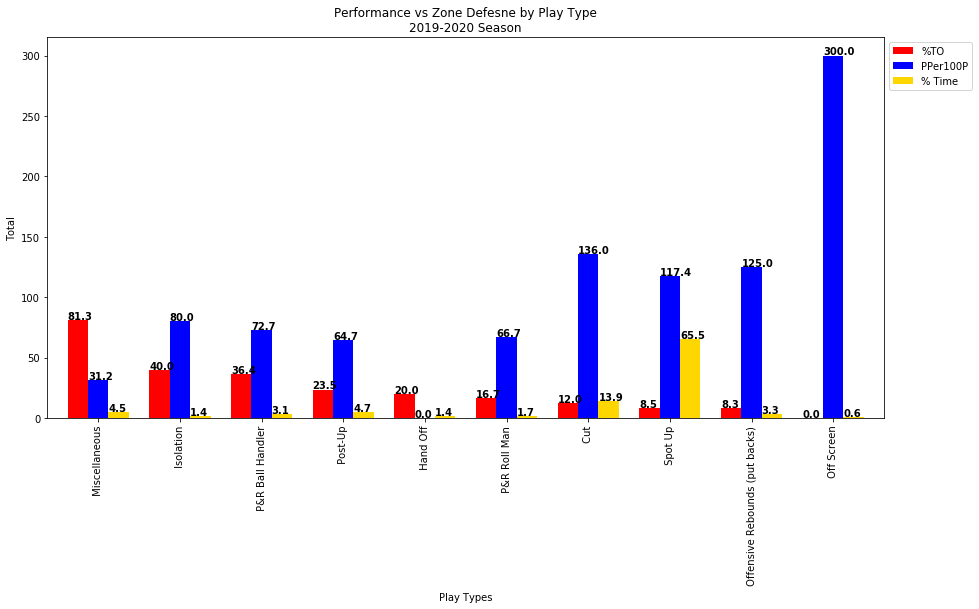

In [67]:
ax = playtypes_zone.sort_values(by='%TO',ascending=False).plot(x='Play Types', y=['%TO','PPer100P','% Time'], kind="bar",width=.75,color=['Red','Blue','Gold'],figsize=(15,7))
plt.ylabel('Total'),plt.title("Performance vs Zone Defesne by Play Type\n2019-2020 Season")
lgd = plt.legend(loc='upper left', bbox_to_anchor=(1,1))
for i in ax.patches:
    ax.text(i.get_x()+.0003, i.get_height()+0.7, \
            str(round((i.get_height()), 2)), fontsize=10, color='Black',
                rotation=0,weight='bold')

Now lets take a look team performance player by player against the zone

In [71]:
# read in the data
team_vs_zone = pd.read_excel('OffvsMan_Zone19_20.xlsx', sheet_name='playersVsZone')
team_vs_zone

,Overall,% Time,Poss,Points,PPP,Rank,Rating,FGm,FGM,FGA,FG%,aFG%,%TO,%FT,%SF,%Score
0,UC San Diego Tritons,1.000,359,397,1.106,0.9,Excellent,146,137,283,0.484,0.627,0.145,0.081,0.067,0.446
1,#14 Christian Oshita,0.228,82,107,1.305,0.9,Excellent,33,37,70,0.529,0.679,0.049,0.110,0.098,0.537
2,#2 Tyrell Roberts,0.203,73,92,1.260,0.88,Excellent,31,30,61,0.492,0.705,0.123,0.041,0.041,0.452
3,#3 Gabe Hadley,0.134,48,38,0.792,0.34,Average,26,13,39,0.333,0.474,0.188,0.021,0.021,0.271
4,#11 Scott Everman,0.128,46,45,0.978,0.57,Good,22,15,37,0.405,0.486,0.087,0.130,0.087,0.435
5,#32 Mickey Howell,0.084,30,29,0.967,0.56,Good,10,9,19,0.474,0.684,0.267,0.100,0.067,0.400
6,#5 Marek Sullivan,0.081,29,40,1.379,0.93,Excellent,5,17,22,0.773,0.818,0.172,0.103,0.069,0.655
7,#44 Chris Hansen,0.025,9,12,1.333,-,-,1,5,6,0.833,0.833,0.222,0.111,0.111,0.667
8,#25 Martin Tombe,0.019,7,13,1.857,-,-,2,4,6,0.667,0.917,0.000,0.143,0.143,0.714
9,#23 Kadeen Rasheed,0.017,6,2,0.333,-,-,4,1,5,0.200,0.200,0.167,0.000,0.000,0.167


In [72]:
percent_cols=['% Time','FG%','aFG%','%TO','%FT','%SF','%Score']
normalize = 100

for column in team_vs_zone.columns:
    if column in percent_cols:
        team_vs_zone[column]=team_vs_zone[column]*normalize

In [73]:
# Drop players whom have less than 25 possesions
df3 = team_vs_zone.drop([0,7,8,9,10,11,12,13,14,15])

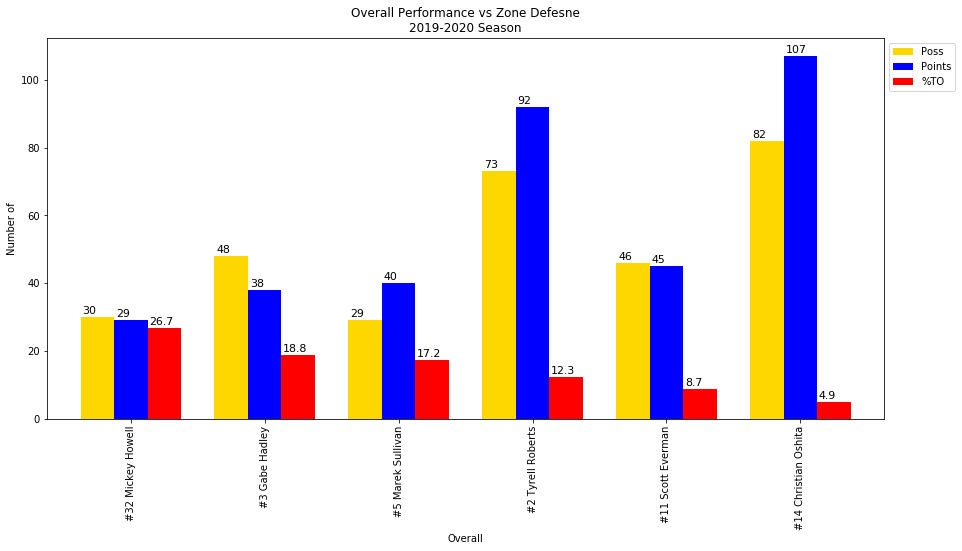

In [74]:
ax = df3.sort_values(by='%TO',ascending=False).plot(x='Overall', y=['Poss','Points','%TO'], kind="bar",width=.75,color=['Gold','Blue','red'],figsize=(15,7))
plt.ylabel('Number of'),plt.title("Overall Performance vs Zone Defesne\n2019-2020 Season")
lgd = plt.legend(loc='upper left', bbox_to_anchor=(1,1))
for i in ax.patches:
    ax.text(i.get_x()+.0135, i.get_height()+1, \
            str(round((i.get_height()), 2)), fontsize=11, color='Black',
                rotation=0)
# plt.savefig('Overall_Performance_vs_Zone_Def.png',bbox_extra_artists=(lgd,),bbox_inches='tight',dpi=130)

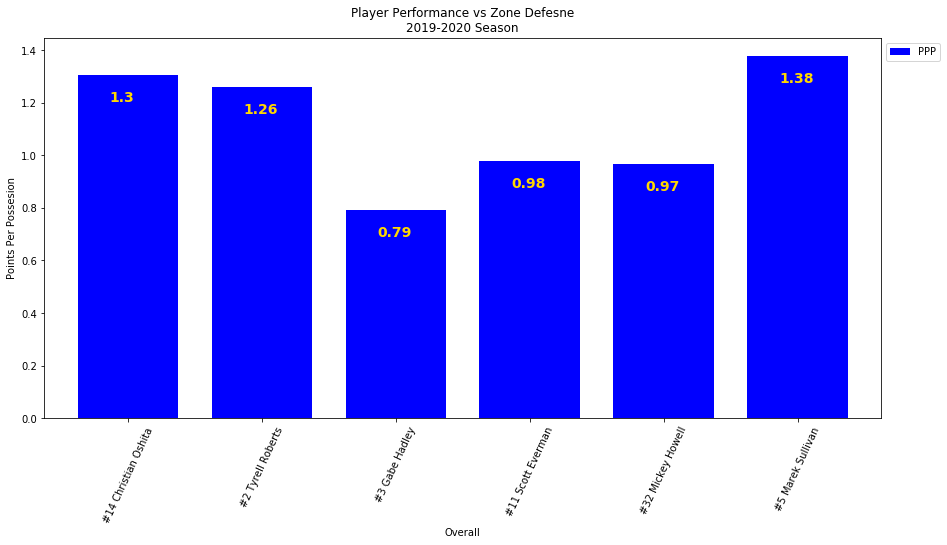

In [75]:
ax = df3.plot(x='Overall', y=['PPP'], kind="bar",width=.75,color=['blue'],figsize=(15,7))
plt.ylabel('Points Per Possesion'),plt.title("Player Performance vs Zone Defesne\n2019-2020 Season"),plt.xticks(rotation=65)
lgd = plt.legend(loc='upper left', bbox_to_anchor=(1,1))
for i in ax.patches:
    ax.text(i.get_x()+0.24, i.get_height()-0.1, \
            str(round((i.get_height()), 2)), fontsize=14, color='Gold',
                rotation=0,weight='bold')
plt.savefig('main_rotation_ZoneDef_performance.png',bbox_extra_artists=(lgd,),bbox_inches='tight',dpi=130)

In [139]:
overall_man = pd.read_excel('OffvsMan_Zone19_20.xlsx', sheet_name='playersVsMan')
overall_man

,Overall,% Time,Poss,Points,PPP,Rank,Rating,FGm,FGM,FGA,FG%,aFG%,%TO,%FT,%SF,%Score
0,UC San Diego Tritons,1.000,1299,1437,1.106,1,Excellent,501,510,1011,0.504,0.602,0.121,0.119,0.075,0.487
1,#2 Tyrell Roberts,0.219,285,306,1.074,0.88,Excellent,129,106,235,0.451,0.549,0.088,0.098,0.056,0.456
2,#14 Christian Oshita,0.182,237,272,1.148,0.95,Excellent,95,93,188,0.495,0.620,0.097,0.122,0.068,0.494
3,#11 Scott Everman,0.120,156,190,1.218,0.98,Excellent,61,74,135,0.548,0.641,0.077,0.077,0.064,0.532
4,#32 Mickey Howell,0.103,134,130,0.970,0.72,Very Good,30,43,73,0.589,0.678,0.313,0.179,0.119,0.463
5,#3 Gabe Hadley,0.089,115,145,1.261,0.99,Excellent,51,51,102,0.500,0.657,0.078,0.061,0.052,0.478
6,#5 Marek Sullivan,0.085,110,129,1.173,0.96,Excellent,32,53,85,0.624,0.647,0.109,0.136,0.100,0.591
7,#44 Chris Hansen,0.080,104,139,1.337,1,Excellent,38,50,88,0.568,0.670,0.058,0.115,0.087,0.577
8,#1 Hugh Baxter,0.028,36,24,0.667,0.15,Below Average,18,9,27,0.333,0.352,0.139,0.111,0.056,0.333
9,#25 Martin Tombe,0.022,28,29,1.036,0.83,Excellent,11,6,17,0.353,0.500,0.143,0.250,0.107,0.464


In [140]:
percent_cols=['% Time','FG%','aFG%','%TO','%FT','%SF','%Score']
normalize = 100

for column in overall_man.columns:
    if column in percent_cols:
        overall_man[column]=overall_man[column]*normalize

In [141]:
df4 = overall_man.drop([0,7,10,11,12,13,14,15,16])

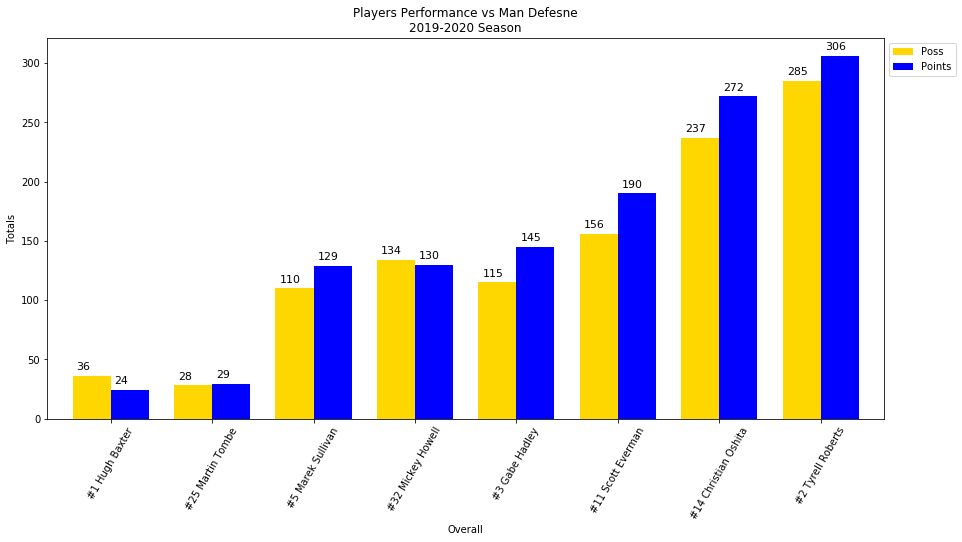

In [142]:
ax = df4.sort_values(by='Points').plot(x='Overall', y=['Poss','Points'], kind="bar",width=.75,color=['Gold','Blue',],figsize=(15,7))
plt.ylabel('Totals'),plt.title("Players Performance vs Man Defesne\n2019-2020 Season"),plt.xticks(rotation=60)
lgd = plt.legend(loc='upper left', bbox_to_anchor=(1,1))
for i in ax.patches:
    ax.text(i.get_x()+.04, i.get_height()+5, \
            str(round((i.get_height()), 2)), fontsize=11, color='Black',
                rotation=0)
plt.savefig('Rotation Players Performance vs Man Defesne.png',bbox_extra_artists=(lgd,),bbox_inches='tight',dpi=130)

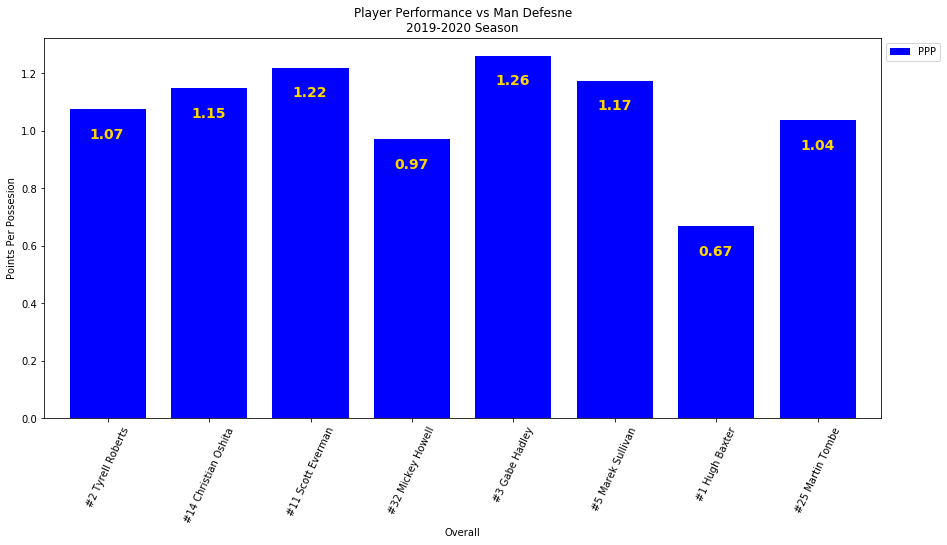

In [143]:
ax = df4.plot(x='Overall', y=['PPP'], kind="bar",width=.75,color=['blue'],figsize=(15,7))
plt.ylabel('Points Per Possesion'),plt.title("Player Performance vs Man Defesne\n2019-2020 Season"),plt.xticks(rotation=65)
lgd = plt.legend(loc='upper left', bbox_to_anchor=(1,1))
for i in ax.patches:
    ax.text(i.get_x()+0.2, i.get_height()-0.1, \
            str(round((i.get_height()), 2)), fontsize=14, color='Gold',
                rotation=0,weight='bold')
# plt.savefig('main_rotation_ZoneDef_performance.png',bbox_extra_artists=(lgd,),bbox_inches='tight',dpi=130)

In [144]:
playtypes_man = pd.read_excel('OffvsMan_Zone19_20.xlsx', sheet_name='playtypesVsMan')

In [145]:
playtypes_man

,Play Types,% Time,Poss,Points,PPP,Rank,Rating,FGm,FGM,FGA,FG%,aFG%,%TO,%FT,%SF,%Score
0,Spot Up,0.280,364,415,1.140,0.99,Excellent,178,139,317,0.438,0.603,0.074,0.060,0.049,0.431
1,Transition,0.170,221,257,1.163,0.94,Excellent,77,87,164,0.530,0.631,0.131,0.149,0.109,0.520
2,P&R Ball Handler,0.149,194,187,0.964,0.95,Excellent,72,71,143,0.497,0.556,0.175,0.113,0.082,0.448
3,P&R Roll Man,0.080,104,109,1.048,0.64,Good,51,40,91,0.440,0.549,0.077,0.058,0.048,0.433
4,Cut,0.075,97,163,1.680,1.00,Excellent,12,70,82,0.854,0.854,0.031,0.196,0.186,0.825
5,Post-Up,0.046,60,64,1.067,0.97,Excellent,21,28,49,0.571,0.571,0.100,0.083,0.067,0.550
6,Off Screen,0.040,52,58,1.115,0.89,Excellent,26,20,46,0.435,0.598,0.077,0.038,0.038,0.423
7,Offensive Rebounds (put backs),0.040,52,65,1.250,0.92,Excellent,15,29,44,0.659,0.670,0.096,0.077,0.058,0.615
8,Isolation,0.037,48,42,0.875,0.70,Very Good,23,15,38,0.395,0.447,0.125,0.125,0.104,0.396
9,Hand Off,0.025,32,25,0.781,0.37,Average,17,9,26,0.346,0.404,0.125,0.094,0.094,0.344


In [146]:
percent_cols=['% Time','FG%','aFG%','%TO','%FT','%SF','%Score']
normalize = 100

for column in playtypes_man.columns:
    if column in percent_cols:
        playtypes_man[column]=playtypes_man[column]*normalize

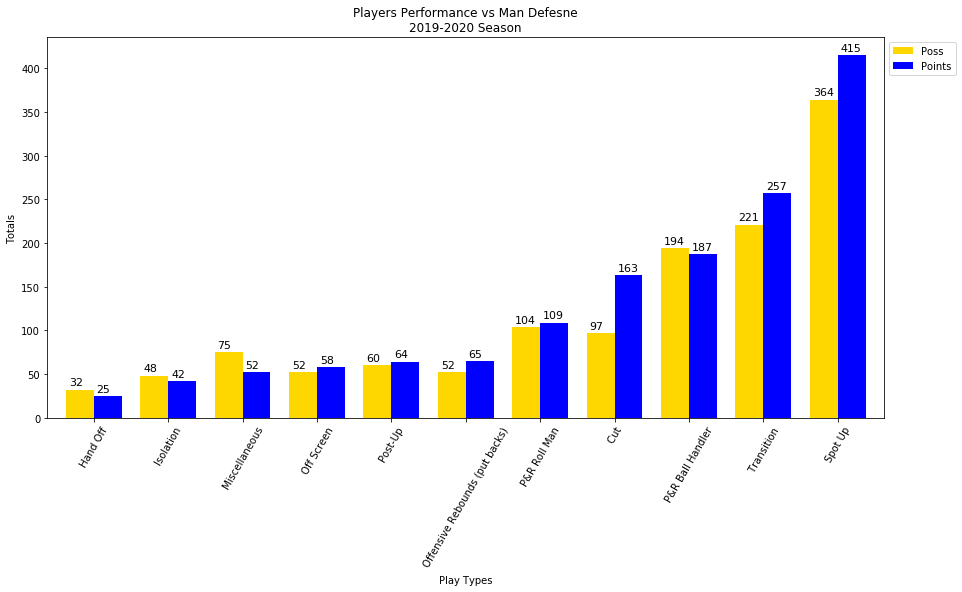

In [147]:
ax = playtypes_man.sort_values(by='Points').plot(x='Play Types', y=['Poss','Points'], kind="bar",width=.75,color=['Gold','Blue',],figsize=(15,7))
plt.ylabel('Totals'),plt.title("Players Performance vs Man Defesne\n2019-2020 Season"),plt.xticks(rotation=60)
lgd = plt.legend(loc='upper left', bbox_to_anchor=(1,1))
for i in ax.patches:
    ax.text(i.get_x()+.04, i.get_height()+5, \
            str(round((i.get_height()), 2)), fontsize=11, color='Black',
                rotation=0)

In [148]:
playtypes_man['PPer100P'] = 100*playtypes_man['PPP']

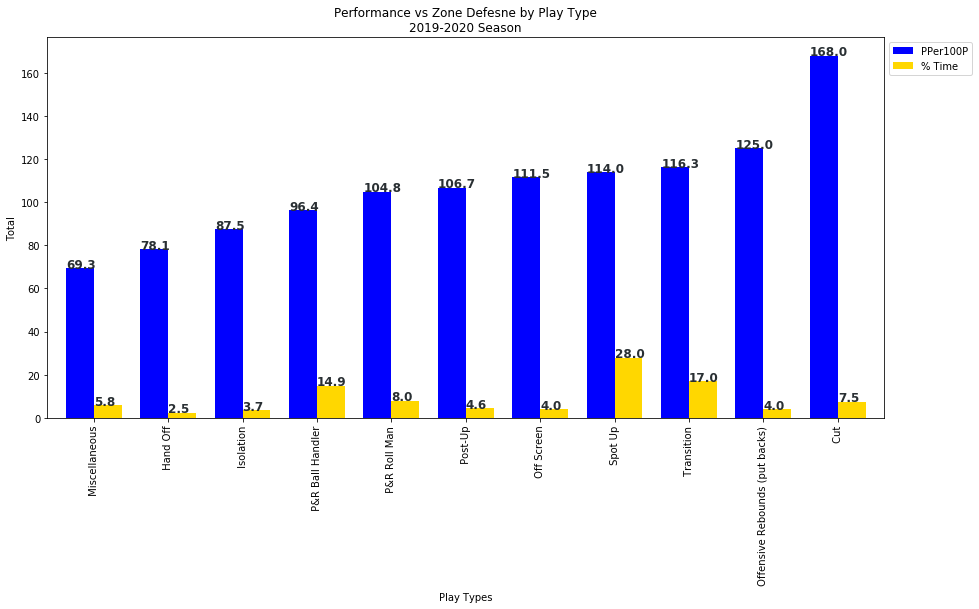

In [149]:
ax = playtypes_man.sort_values(by='PPer100P').plot(x='Play Types', y=['PPer100P','% Time'], kind="bar",width=.75,color=['Blue','Gold','red'],figsize=(15,7))
plt.ylabel('Total'),plt.title("Performance vs Zone Defesne by Play Type\n2019-2020 Season")
lgd = plt.legend(loc='upper left', bbox_to_anchor=(1,1))
for i in ax.patches:
    ax.text(i.get_x()+.003, i.get_height()+0.09, \
            str(round((i.get_height()), 2)), fontsize=12, color='#292f33',
                rotation=0,weight='bold')

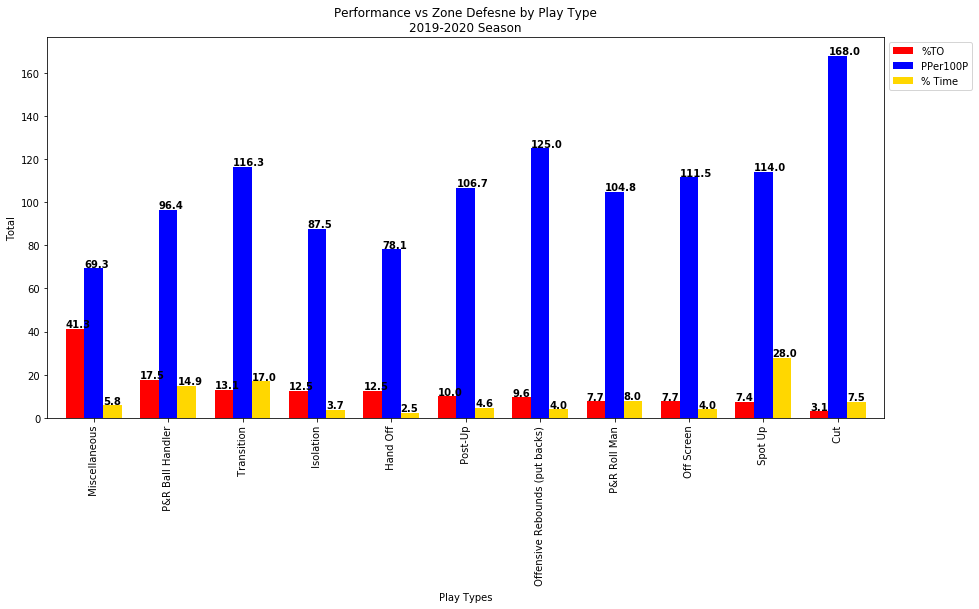

In [150]:
ax = playtypes_man.sort_values(by='%TO',ascending=False).plot(x='Play Types', y=['%TO','PPer100P','% Time'], kind="bar",width=.75,color=['Red','Blue','Gold'],figsize=(15,7))
plt.ylabel('Total'),plt.title("Performance vs Zone Defesne by Play Type\n2019-2020 Season")
lgd = plt.legend(loc='upper left', bbox_to_anchor=(1,1))
for i in ax.patches:
    ax.text(i.get_x()+.0003, i.get_height()+0.7, \
            str(round((i.get_height()), 2)), fontsize=10, color='Black',
                rotation=0,weight='bold')

In [151]:
df5 = pd.read_excel('OffvsMan_Zone19_20.xlsx', sheet_name='TeamVsZoneandMan')
df5['%Time'] = [.78,.22]
df5=df5.drop(columns=['% Time','PPP'])

In [152]:
Expected_PPP_againstMan = sum(playtypes_man['PPP'])/len(playtypes_man['PPP'])
Expected_PPP_againstMan

1.0705454545454545

In [153]:
df5['Expected_PPP'] = [Expected_PPP_againstMan,Expected_PPP_againstZone]

In [154]:
df5

,Overall,Poss,Points,Rank,Rating,FGm,FGM,FGA,FG%,aFG%,%TO,%FT,%SF,%Score,%Time,Expected_PPP
0,Tritons vs Man def,1299,1437,1.0,Excellent,501,510,1011,0.504,0.602,0.121,0.119,0.075,0.487,0.78,1.070545
1,Tritons vs Zone Def,359,397,0.9,Excellent,146,137,283,0.484,0.627,0.145,0.081,0.067,0.446,0.22,0.993700


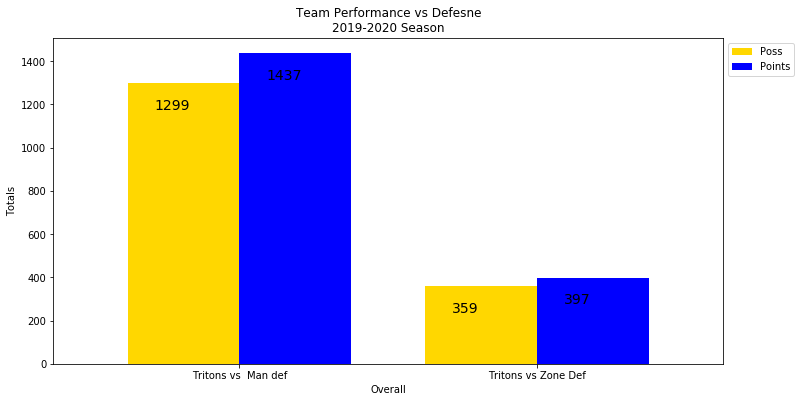

In [155]:
ax = df5.plot(x='Overall', y=['Poss','Points'], kind="bar",width=.75,color=['Gold','Blue',],figsize=(12,6))
plt.ylabel('Totals'),plt.title("Team Performance vs Defesne\n2019-2020 Season"),plt.xticks(rotation=0)
lgd = plt.legend(loc='upper left', bbox_to_anchor=(1,1))
for i in ax.patches:
    ax.text(i.get_x()+0.09, i.get_height()-120, \
            str(round((i.get_height()), 2)), fontsize=14, color='Black',
                rotation=0,weight=None)

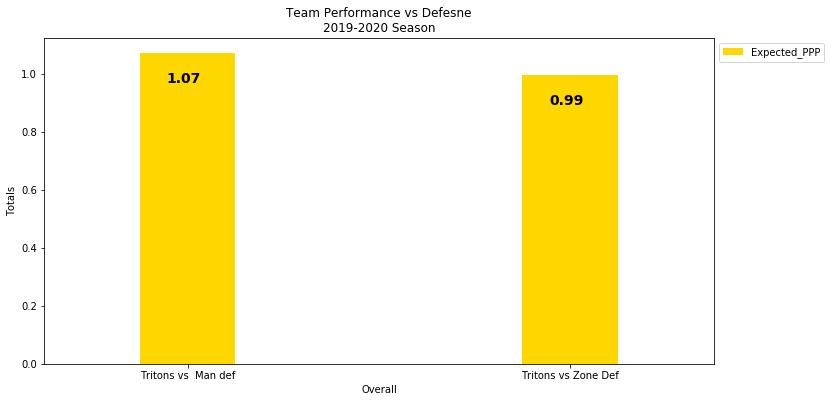

In [164]:
ax = df5.plot(x='Overall', y=['Expected_PPP'], kind="bar",width=.25,color=['Gold','Blue'],figsize=(12,6))
plt.ylabel('Totals'),plt.title("Team Performance vs Defesne\n2019-2020 Season"),plt.xticks(rotation=0)
lgd = plt.legend(loc='upper left', bbox_to_anchor=(1,1))
for i in ax.patches:
    ax.text(i.get_x()+0.07, i.get_height()-0.1, \
            str(round((i.get_height()), 2)), fontsize=14, color='Black',
                rotation=0,weight='bold')

In [161]:
df5

,Overall,Poss,Points,Rank,Rating,FGm,FGM,FGA,FG%,aFG%,%TO,%FT,%SF,%Score,%Time,Expected_PPP
0,Tritons vs Man def,1299,1437,1.0,Excellent,501,510,1011,0.504,0.602,0.121,0.119,0.075,0.487,0.78,1.070545
1,Tritons vs Zone Def,359,397,0.9,Excellent,146,137,283,0.484,0.627,0.145,0.081,0.067,0.446,0.22,0.993700


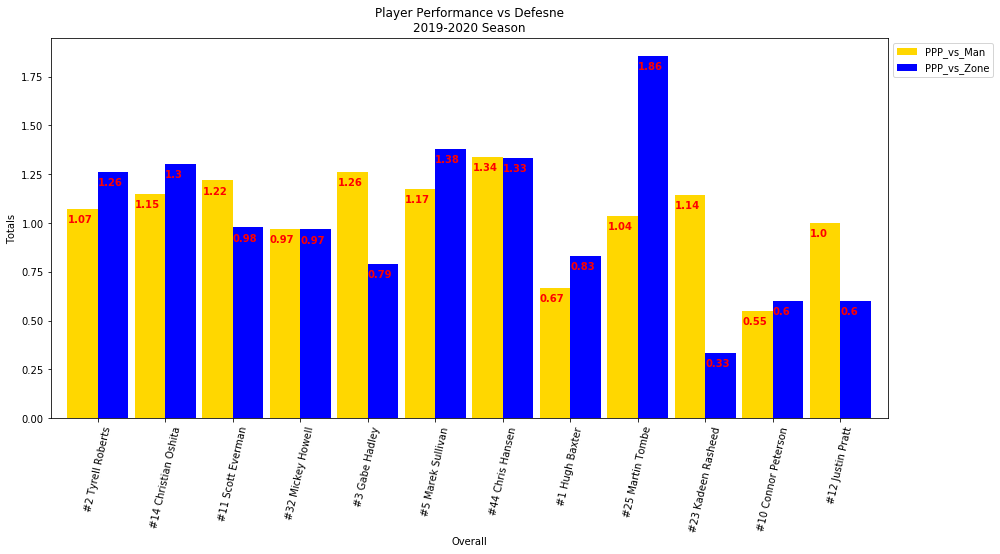

In [260]:
# I want to see how the players with more than 20 possesions PPP is effected by type of defense.

ax = df7.drop([12,13,14,15]).reset_index(drop=True).plot(x='Overall', y=['PPP_vs_Man','PPP_vs_Zone'], kind="bar",width=.9,color=['Gold','Blue'],figsize=(15,7))
plt.ylabel('Totals'),plt.title("Player Performance vs Defesne\n2019-2020 Season"),plt.xticks(rotation=77)
lgd = plt.legend(loc='upper left', bbox_to_anchor=(1,1))
for i in ax.patches:
    ax.text(i.get_x()-0.0011, i.get_height()-0.07, \
            str(round((i.get_height()), 2)), fontsize=10, color='Red',
                rotation=0,weight='bold')

In [196]:
df7 = pd.DataFrame()
df7['Overall'] = overall_man['Overall']
df7['PPP_vs_Man'] = overall_man['PPP']
# because some of the players did not match in zone and man datasets I manually entered them
df7['PPP_vs_Zone'] = [1.106,1.260,1.305,0.978,0.967,0.792,1.379,1.333,0.833,1.857,\
                    0.333,0.600,0.600,0.400,0.000,0.000,1.200]
df7=df7.drop([0]).reset_index(drop=True)

In [197]:
df7

,Overall,PPP_vs_Man,PPP_vs_Zone
0,#2 Tyrell Roberts,1.074,1.260
1,#14 Christian Oshita,1.148,1.305
2,#11 Scott Everman,1.218,0.978
3,#32 Mickey Howell,0.970,0.967
4,#3 Gabe Hadley,1.261,0.792
5,#5 Marek Sullivan,1.173,1.379
6,#44 Chris Hansen,1.337,1.333
7,#1 Hugh Baxter,0.667,0.833
8,#25 Martin Tombe,1.036,1.857
9,#23 Kadeen Rasheed,1.143,0.333


## A Fair Warning:
Everything Below This is just me nerding out with graphs, and data. 

I wanted to check out various density graphs and much more that might be useful later.



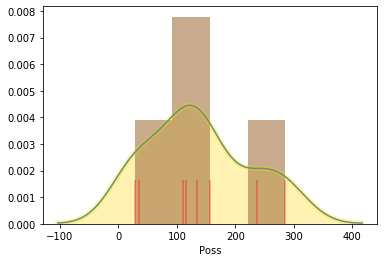

In [184]:
# sns.distplot( a=df4["Poss"], hist=True, kde=True, rug=True )
# #sns.plt.show()
 
# To change parameters of rug
sns.distplot( a=df4["Poss"], rug=True,
rug_kws={"color":'r', "alpha":0.3, "linewidth": 2, "height":0.2 }
)
 
# To change parameters of density distribution
sns.distplot( a=df4["Poss"], kde=True,
kde_kws={"color": "gold", "alpha":0.3, "linewidth": 5, "shade":True })
